#  spectra for AuxTel and Equivalent width with Specutils For Holograms

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : April 7th  2021
- update : April 15th 2021 : get equivalent width with specutils, including stat error with bootstrap
- update : April 16th 2021 : write eqw in csv file after correcting important bugs
- update : April 17th 2021 : plot eqw vs time
- version v1.0

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [3]:
from datetime import datetime,date

In [4]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [5]:
string_date

'2021-07-07'

In [6]:
from iminuit import Minuit
import iminuit

In [7]:
iminuit.__version__

'2.2.0'

In [8]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [9]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [10]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [11]:
from time import sleep

In [12]:
from astropy.time import Time
import astropy.units as u

# Function

In [13]:
def file_target(filename):
    m=re.findall('^Cor_holo4_003_.*_(.*)_[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*[.]fits$',filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []

# Path

In [14]:
path_auxtel="/sps/lsst/groups/auxtel"
path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
path_spectractor_config=os.path.join(path_spectractor,"config")
path_images=os.path.join(path_auxtel,"data/2021/holo/localreduced/2021-07-06")

In [15]:
config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")

# Logbook for file selection

In [16]:
filename_logbook='logbooks/auxtelholologbook_2021_07_06_v2.0.csv'

In [17]:
df=pd.read_csv(filename_logbook,index_col=0)

In [18]:
pd.set_option('display.max_rows', None)

In [19]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-07T01:16:33.033,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000098.fits,98,HD120144,RG610,holo4_003,1.112792,20.0,...,7.0,16.0,11.6,256.0,2130.0,NaN,NaN,,1.0,1.0
1,1,2021-07-07T01:17:01.054,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000099.fits,99,HD120144,RG610,holo4_003,1.113402,20.0,...,7.0,16.0,11.6,256.0,2130.0,NaN,NaN,,1.0,1.0
2,2,2021-07-07T01:17:25.525,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000100.fits,100,HD120144,RG610,holo4_003,1.113971,20.0,...,7.0,16.0,11.6,256.0,2300.0,NaN,NaN,,1.0,1.0
3,3,2021-07-07T01:17:50.010,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000101.fits,101,HD120144,RG610,holo4_003,1.114548,20.0,...,7.0,15.0,13.1,256.0,2300.0,NaN,NaN,,1.0,1.0
4,4,2021-07-07T01:18:14.601,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000102.fits,102,HD120144,RG610,holo4_003,1.115124,20.0,...,7.0,15.0,13.1,256.0,2300.0,NaN,NaN,,1.0,1.0
5,5,2021-07-07T01:18:38.991,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000103.fits,103,HD120144,RG610,holo4_003,1.115701,20.0,...,7.1,15.0,10.9,256.0,2300.0,NaN,NaN,,1.0,1.0
6,6,2021-07-07T01:19:03.593,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000104.fits,104,HD120144,RG610,holo4_003,1.116286,20.0,...,7.1,15.0,10.9,256.0,2300.0,NaN,NaN,,1.0,1.0
7,7,2021-07-07T01:19:27.983,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000105.fits,105,HD120144,RG610,holo4_003,1.116869,20.0,...,7.1,15.0,10.9,256.0,2300.0,NaN,NaN,,1.0,1.0
8,8,2021-07-07T01:19:52.570,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000106.fits,106,HD120144,RG610,holo4_003,1.117460,20.0,...,7.2,14.0,9.9,256.0,2300.0,NaN,NaN,,1.0,1.0


# Selection of input file

In [20]:
df_good=df[df["quality"]==1]

In [21]:
for spectra_file in df_good["file"]:
    print(spectra_file)

Cor_holo4_003_RG610_HD120144_20210706_000098.fits
Cor_holo4_003_RG610_HD120144_20210706_000099.fits
Cor_holo4_003_RG610_HD120144_20210706_000100.fits
Cor_holo4_003_RG610_HD120144_20210706_000101.fits
Cor_holo4_003_RG610_HD120144_20210706_000102.fits
Cor_holo4_003_RG610_HD120144_20210706_000103.fits
Cor_holo4_003_RG610_HD120144_20210706_000104.fits
Cor_holo4_003_RG610_HD120144_20210706_000105.fits
Cor_holo4_003_RG610_HD120144_20210706_000106.fits


In [22]:
dir_spectra="outputs_reprocess"

In [23]:
all_files=os.listdir(dir_spectra)

In [24]:
all_spectra_files = []
for filename in all_files:
    if re.search("_spectrum.fits$",filename):
        all_spectra_files.append(filename)
N=len(all_spectra_files)

In [25]:
all_good_spectra_spectrum_files=[]

idx=0
for good_spectra_file in df_good["file"]:
    good_spectra_spectrum_file = good_spectra_file.split(".")[0]+"_spectrum.fits"
    if good_spectra_spectrum_file in all_spectra_files:
        print(idx,") : found {}".format(good_spectra_spectrum_file))
        all_good_spectra_spectrum_files.append(good_spectra_spectrum_file)
        idx+=1
    

0 ) : found Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits
1 ) : found Cor_holo4_003_RG610_HD120144_20210706_000099_spectrum.fits
2 ) : found Cor_holo4_003_RG610_HD120144_20210706_000100_spectrum.fits
3 ) : found Cor_holo4_003_RG610_HD120144_20210706_000101_spectrum.fits
4 ) : found Cor_holo4_003_RG610_HD120144_20210706_000102_spectrum.fits
5 ) : found Cor_holo4_003_RG610_HD120144_20210706_000103_spectrum.fits
6 ) : found Cor_holo4_003_RG610_HD120144_20210706_000104_spectrum.fits
7 ) : found Cor_holo4_003_RG610_HD120144_20210706_000105_spectrum.fits


0 ) Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits   outputs_reprocess/Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits


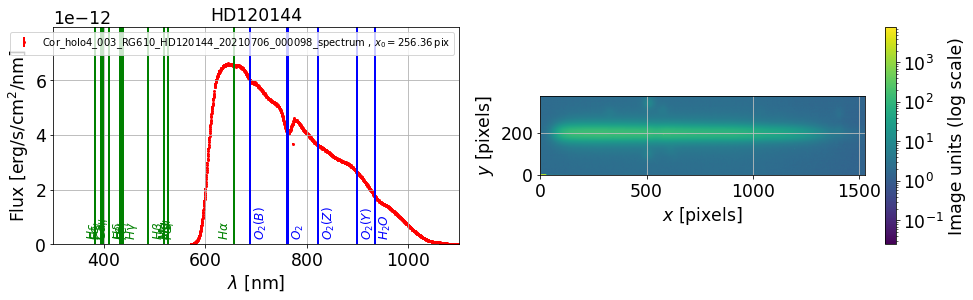

1 ) Cor_holo4_003_RG610_HD120144_20210706_000099_spectrum.fits   outputs_reprocess/Cor_holo4_003_RG610_HD120144_20210706_000099_spectrum.fits


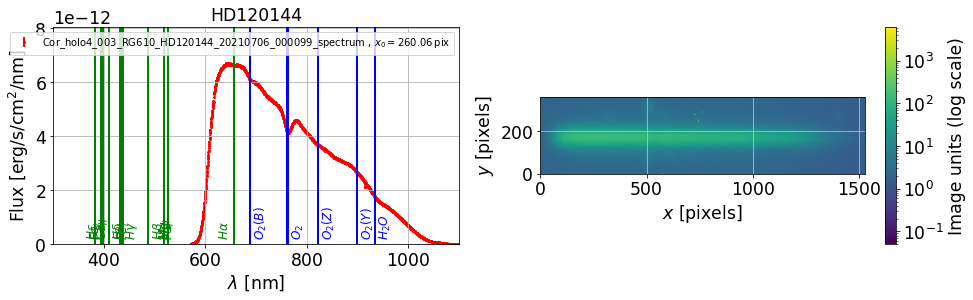

2 ) Cor_holo4_003_RG610_HD120144_20210706_000100_spectrum.fits   outputs_reprocess/Cor_holo4_003_RG610_HD120144_20210706_000100_spectrum.fits


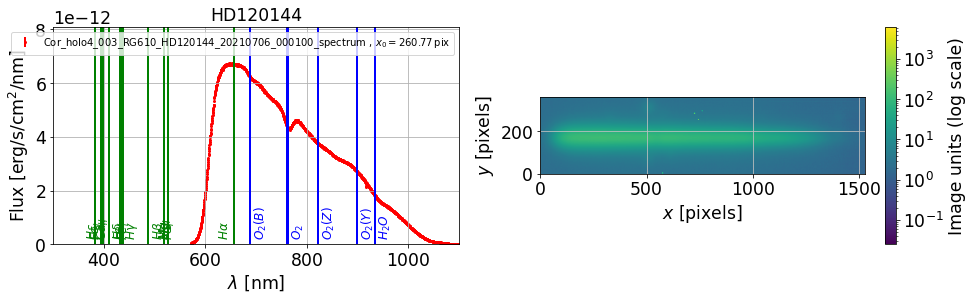

3 ) Cor_holo4_003_RG610_HD120144_20210706_000101_spectrum.fits   outputs_reprocess/Cor_holo4_003_RG610_HD120144_20210706_000101_spectrum.fits


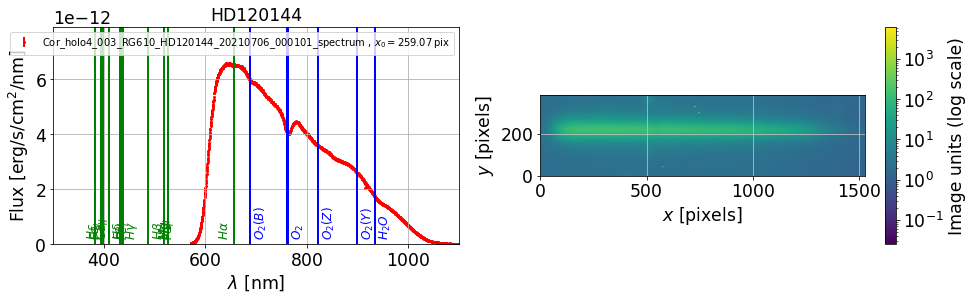

4 ) Cor_holo4_003_RG610_HD120144_20210706_000102_spectrum.fits   outputs_reprocess/Cor_holo4_003_RG610_HD120144_20210706_000102_spectrum.fits


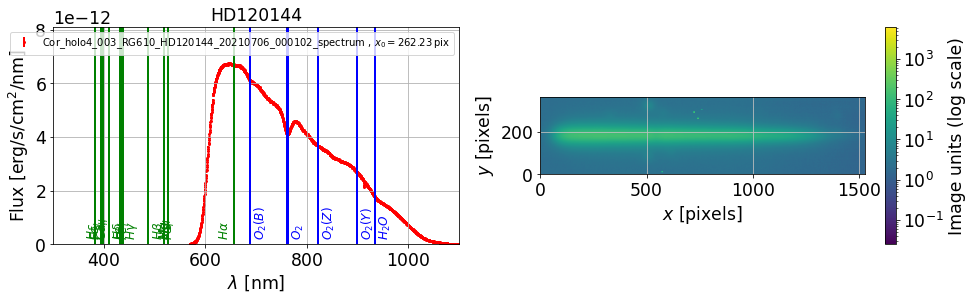

5 ) Cor_holo4_003_RG610_HD120144_20210706_000103_spectrum.fits   outputs_reprocess/Cor_holo4_003_RG610_HD120144_20210706_000103_spectrum.fits


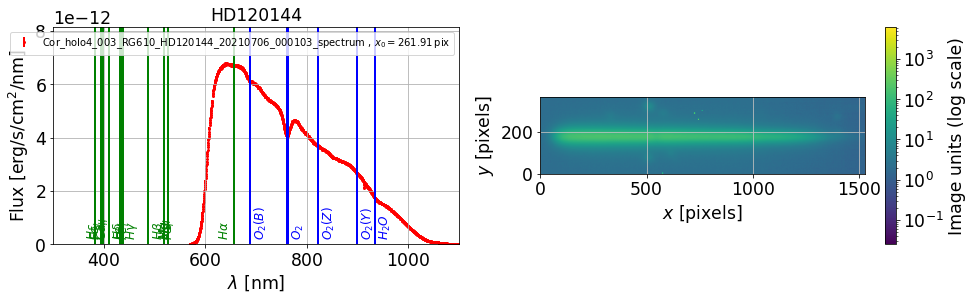

6 ) Cor_holo4_003_RG610_HD120144_20210706_000104_spectrum.fits   outputs_reprocess/Cor_holo4_003_RG610_HD120144_20210706_000104_spectrum.fits


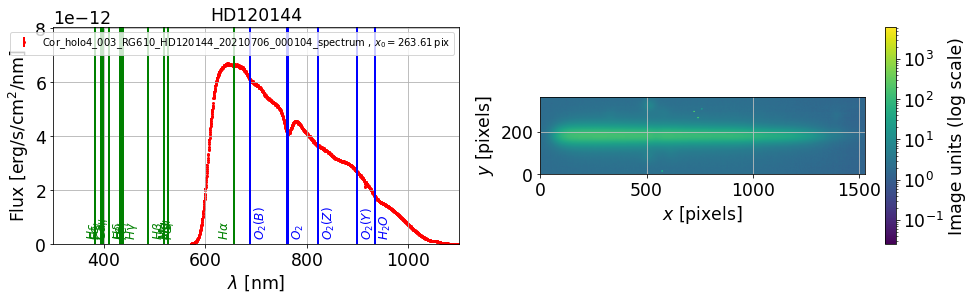

7 ) Cor_holo4_003_RG610_HD120144_20210706_000105_spectrum.fits   outputs_reprocess/Cor_holo4_003_RG610_HD120144_20210706_000105_spectrum.fits


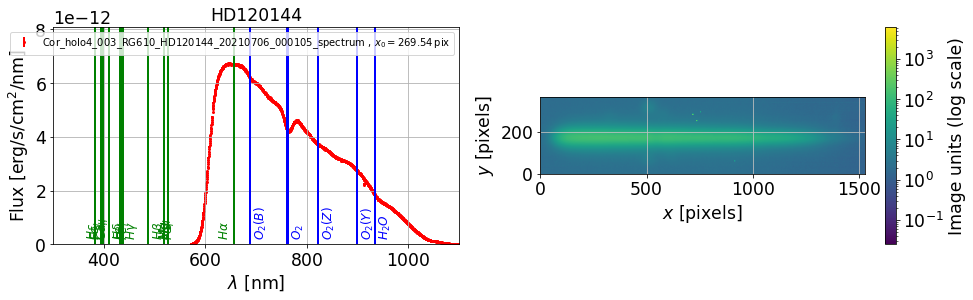

In [26]:
parameters.DISPLAY=False

infos = []

idx=0
for filename in all_good_spectra_spectrum_files:
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    fullfilename = os.path.join(dir_spectra,filename)
    
    print(idx,")",filename," ",fullfilename)
    
    
    #try:
    #    s=Spectrum(fullfilename, config="config/auxtel_quicklook.ini")
    #    print("Success First Connection with file "+ fullfilename)
    #    break           
    #except requests.exceptions.ConnectionError:
    #except:
    #    print("Connection refused, will retry")
    #    sleep(5)
    #    try:
    #        print("try connection again ")    
    #        s=Spectrum(fullfilename, config="config/auxtel_quicklook.ini")
    #        print("Success Second Connection ")
    #        break
        
        #except requests.exceptions.ConnectionError:
    #    except:
    #        print("Connection refused twice, give up")
    #        continue
            
    #    continue
                   
    
    s=Spectrum(fullfilename, config=config)
    label=filename.split('.')[0]+" "
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=fullfilename.replace("_spectrum","_spectrogram")
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    idx+=1
    

In [27]:
df_infos=pd.DataFrame(infos,columns=["idx","date_obs","airmass","temperature","pressure","humidity"])

In [28]:
df_infos.set_index('idx',inplace=True)

In [29]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [30]:
all_reftime=np.array(all_reftime)

In [31]:
df_infos["reftime"]=all_reftime

In [32]:
df_infos["eqw_h2o"] = np.nan
df_infos["eqw_o2"] = np.nan
df_infos["eqw_o2_spec"] = np.nan

In [33]:
df_infos

,date_obs,airmass,temperature,pressure,humidity,reftime,eqw_h2o,eqw_o2,eqw_o2_spec
idx,,,,,,,,,
0,2021-07-07T01:16:18.894,1.113036,7.0,742.35,16.0,0.000000,NaN,NaN,NaN
1,2021-07-07T01:16:46.919,1.113668,7.0,742.35,16.0,0.007785,NaN,NaN,NaN
2,2021-07-07T01:17:11.390,1.114239,7.0,742.35,16.0,0.014582,NaN,NaN,NaN
3,2021-07-07T01:17:35.866,1.114817,7.0,742.25,15.0,0.021381,NaN,NaN,NaN
4,2021-07-07T01:18:00.451,1.115396,7.0,742.25,15.0,0.028210,NaN,NaN,NaN
5,2021-07-07T01:18:24.863,1.115972,7.1,742.35,15.0,0.034991,NaN,NaN,NaN
6,2021-07-07T01:18:49.445,1.116559,7.1,742.35,15.0,0.041820,NaN,NaN,NaN
7,2021-07-07T01:19:13.841,1.117143,7.1,742.35,15.0,0.048596,NaN,NaN,NaN


# Selection of spectra and equivalent width calculation

In [34]:
from astropy import units as u
from astropy.visualization import quantity_support

quantity_support()  # for getting units on the axes below  

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f20b2c8ffd0>

In [35]:
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum,fit_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from astropy.modeling import models
from specutils.manipulation import extract_region

In [36]:

IDXSEL=0
filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")

In [37]:
thetitle=str(IDXSEL)+") "+filename_SEL

In [38]:
thetitle

'0) Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits'

In [39]:
fullfilename_SEL

'outputs_reprocess/Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits'

## Load spectrum and Spectrogram

In [40]:
s=Spectrum(fullfilename_SEL, config=config)
s.load_spectrogram(fullfilename_spectrogram_SEL) 

In [41]:
lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)

In [42]:
s.lines = lines

In [43]:
lambdas = np.arange(300,1000,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)

In [44]:
global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)

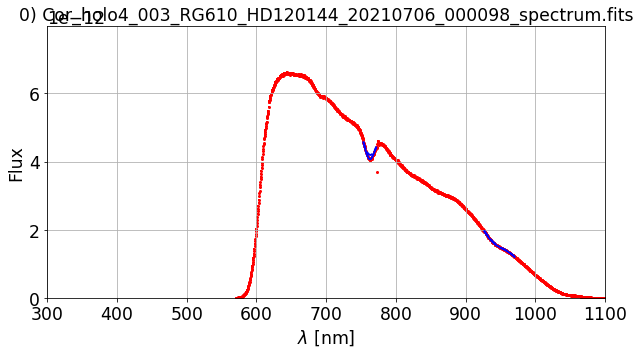

In [45]:
fig = plt.figure(figsize=(10,5))
plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
lines.plot_detected_lines(plt.gca())
thetitle=str(IDXSEL)+") "+ filename_SEL
plt.title(thetitle)
plt.show()

In [46]:
lines.print_detected_lines()

Line,Tabulated,Detected,Shift,FWHM,Amplitude,SNR,Chisq,Eqwidth_mod,Eqwidth_data
,nm,nm,nm,nm,,,reduced,nm,nm
bytes12,float32,float32,float32,float32,float32,float32,float32,float32,float32
,760.3,762.1847,1.8846991,9.377151,-1.304406e-13,9.743581,1.2106968,0.30591413,1.6524806


## with specutils

### Convert in specutils units

In [47]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

## Equivalent width calculation with Automatic line plot

In [48]:
def ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True)
    
    - input :
    
    
    - output :
    
    """
            
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
    
    eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
    eqw2=equivalent_width(cont_norm_spec, regions=sub_region)  
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\AA$ ".format(eqw1.value)
        eqw_str2="$Eqw_2$ = {:2.2f} $\AA$ ".format(eqw2.value)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        
    return eqw1.value,eqw2.value     

In [49]:
def ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline)
    
    - input :
    
    
    - output :
    
    """
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
         
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
       
    eqw10=equivalent_width(cont_norm_spec, regions=line_region).value 
    eqw20=equivalent_width(cont_norm_spec, regions=sub_region).value 
       
    # Bootstrap
    
    
    eqw1_set=np.zeros(NN)
    eqw2_set=np.zeros(NN)
    size=len(specerr.flux)
    
    # loop on trials 
    for idx in np.arange(NN):
        
        # random generator for errors
        s = np.random.normal(0, 1, size)
        
        # new flux
        newspec = Spectrum1D(spectral_axis=spec.spectral_axis, flux=spec.flux+specerr.flux*s)
              
    
        # region where one extract the spectrum
        sub_spectrum = extract_region(newspec, sub_region)
    
        # initialisaition of linear model
        g_init = models.Linear1D(slope=0,intercept=1e-12)
    
        # fit on sub-spectrum
        g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
        # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
        g2_fit = fit_continuum(newspec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
        y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
        y_continuum_fitted2 = g2_fit(newspec.spectral_axis)
    
        # normalize the spectrum
        cont_norm_spec = newspec/ y_continuum_fitted2 
    
    
        eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
        eqw2=equivalent_width(cont_norm_spec, regions=sub_region) 
        
        
        eqw1_set[idx]=eqw1.value
        eqw2_set[idx]=eqw2.value
        
     
    eqw1_std=eqw1_set.std()
    eqw2_std=eqw2_set.std()
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw10,eqw1_std)
        eqw_str2="$Eqw_2$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw20,eqw2_std)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
               
        
    return eqw10,eqw20,eqw1_set,eqw2_set     

### The original spectrum

#### O2 line

In [50]:
wlmin=10*(O2_1.wavelength-30)*u.AA
wlmax=10*(O2_1.wavelength+30)*u.AA
wlminline=10*(O2_1.wavelength-10)*u.AA
wlmaxline=10*(O2_1.wavelength+10)*u.AA

2021-07-07 21:35:09  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:35:09  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


Text(0.5, 0.98, '0) Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits')

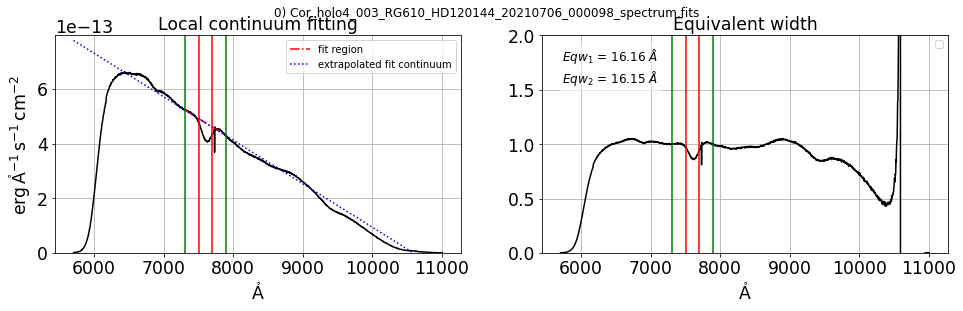

In [51]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

2021-07-07 21:35:11  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:35:11  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


Text(0.5, 0.98, '0) Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits')

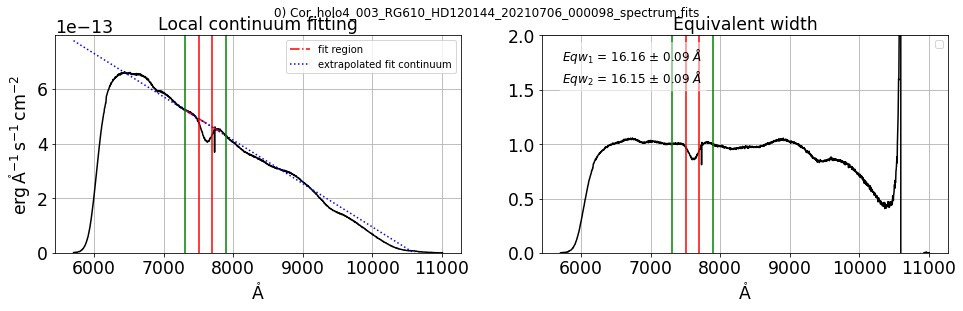

In [52]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

Text(0.5, 0.98, '0) Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits')

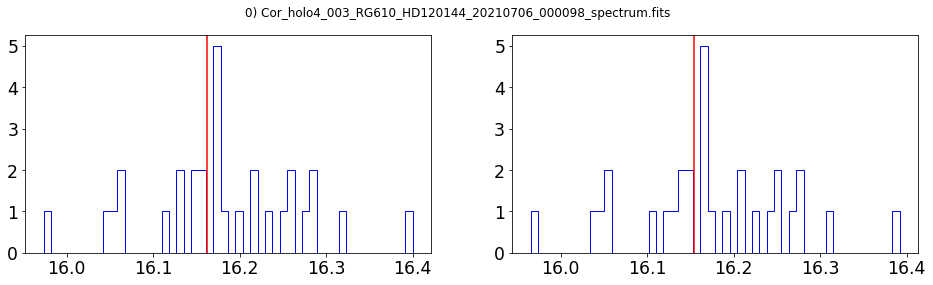

In [53]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color="b");
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

### H2O line

In [54]:
wlmin=10*(H2O_1.wavelength-30)*u.AA
wlmax=10*(H2O_2.wavelength+30)*u.AA
wlminline=10*(H2O_1.wavelength-12)*u.AA
wlmaxline=10*(H2O_2.wavelength+10)*u.AA

In [55]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

2021-07-07 21:35:54  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:35:54  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


Text(0.5, 0.98, '0) Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits')

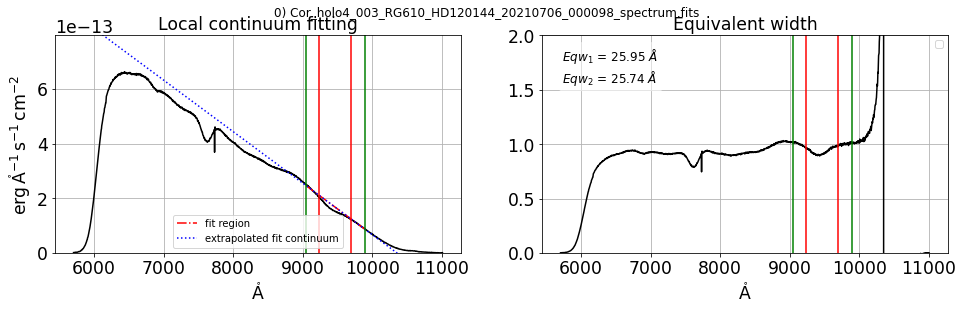

In [56]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

2021-07-07 21:35:56  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:35:56  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


Text(0.5, 0.98, '0) Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits')

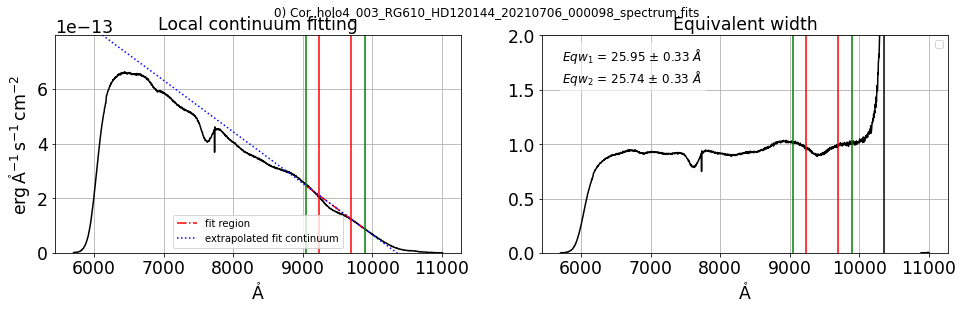

In [57]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

Text(0.5, 0.98, '0) Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits')

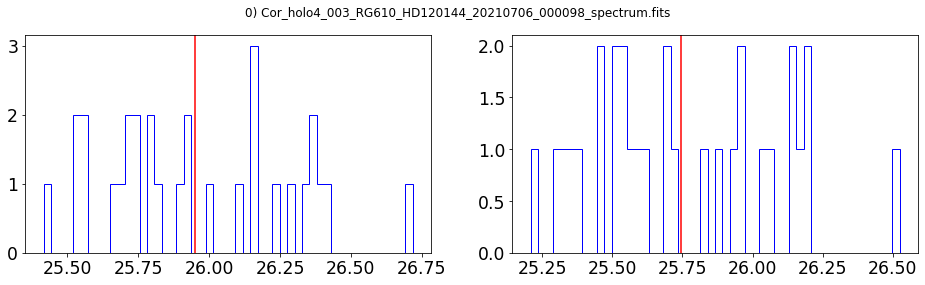

In [58]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color='b');
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

# Loop on spectra with Spectractor

0 )  Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits


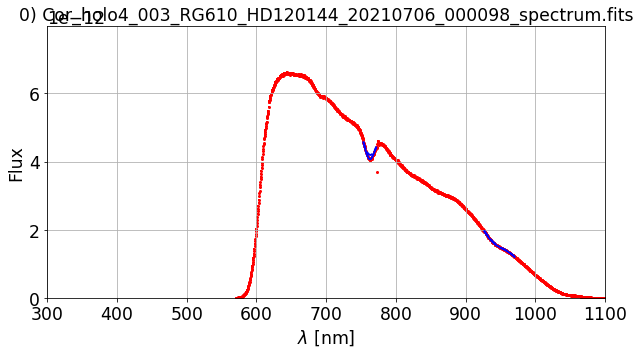

Line Tabulated Detected   Shift   ...   Chisq   Eqwidth_mod Eqwidth_data
         nm       nm        nm    ...  reduced       nm          nm     
---- --------- -------- --------- ... --------- ----------- ------------
         760.3 762.1847 1.8846991 ... 1.2106968  0.30591413    1.6524806
1.6524806
1 )  Cor_holo4_003_RG610_HD120144_20210706_000099_spectrum.fits


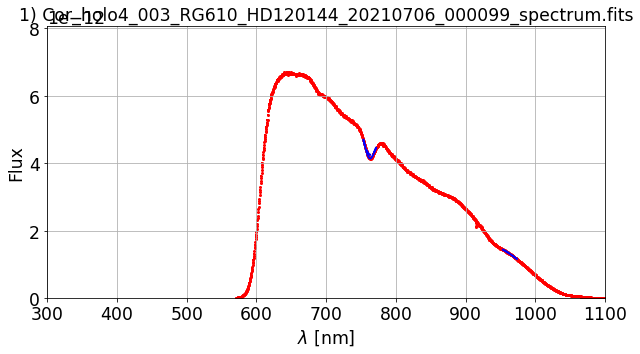

Line Tabulated  Detected   Shift   ...   Chisq   Eqwidth_mod Eqwidth_data
         nm        nm        nm    ...  reduced       nm          nm     
---- --------- --------- --------- ... --------- ----------- ------------
         760.3 762.13165 1.8316826 ... 0.9143785  0.24297738    1.2212942
1.2212942
2 )  Cor_holo4_003_RG610_HD120144_20210706_000100_spectrum.fits


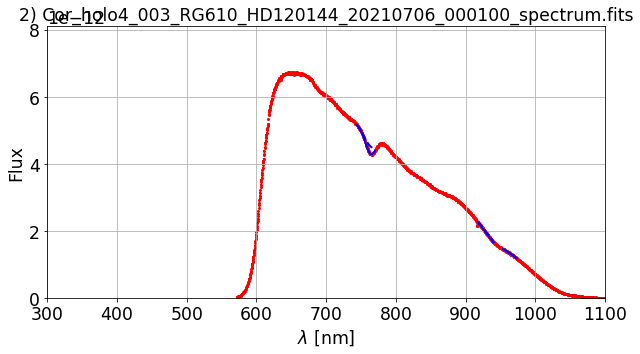

  Line  Tabulated  Detected    Shift     ...   Chisq    Eqwidth_mod Eqwidth_data
            nm        nm         nm      ...  reduced        nm          nm     
------- --------- --------- ------------ ... ---------- ----------- ------------
            760.3   762.975    2.6749878 ... 0.82964814   0.6872422    3.2985058
$H_2 O$     935.0 935.00244 0.0024664758 ...   0.603184  0.87887025     8.924296
3.2985058
3 )  Cor_holo4_003_RG610_HD120144_20210706_000101_spectrum.fits


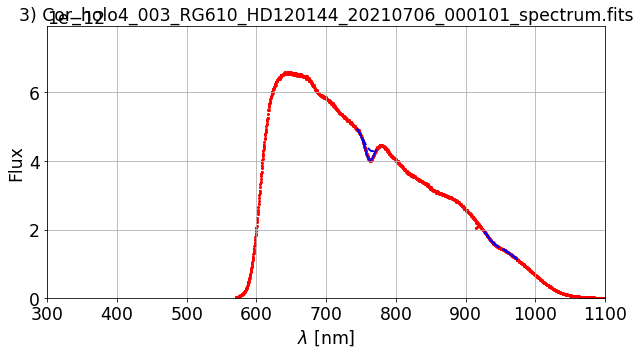

Line Tabulated Detected   Shift   ...   Chisq   Eqwidth_mod Eqwidth_data
         nm       nm        nm    ...  reduced       nm          nm     
---- --------- -------- --------- ... --------- ----------- ------------
         760.3 761.7057 1.4057181 ... 0.8745608   0.8734762    2.4538293
2.4538293
4 )  Cor_holo4_003_RG610_HD120144_20210706_000102_spectrum.fits


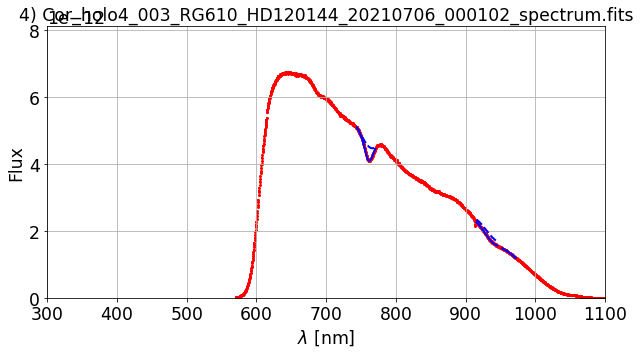

  Line  Tabulated Detected    Shift     ...   Chisq    Eqwidth_mod Eqwidth_data
            nm       nm         nm      ...  reduced        nm          nm     
------- --------- -------- ------------ ... ---------- ----------- ------------
            760.3 760.7038   0.40379867 ...  0.6771636   1.1461545    2.4642198
$H_2 O$     935.0 935.0006 0.0005934101 ... 0.92154175   3.3577616    123.60789
2.4642198
5 )  Cor_holo4_003_RG610_HD120144_20210706_000103_spectrum.fits


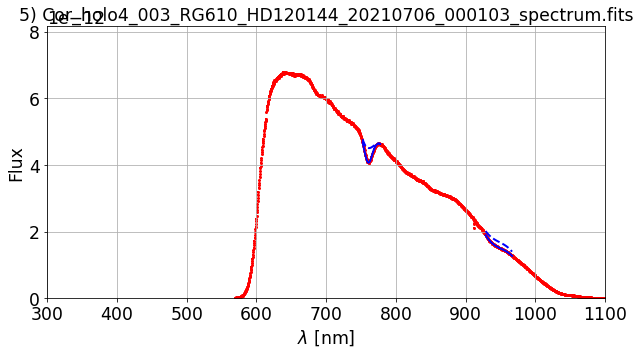

  Line  Tabulated  Detected    Shift     ...   Chisq   Eqwidth_mod Eqwidth_data
            nm        nm         nm      ...  reduced       nm          nm     
------- --------- --------- ------------ ... --------- ----------- ------------
            760.3  760.5697     0.269706 ... 1.0026081   1.1436347     2.897442
$H_2 O$     935.0 934.99457 -0.005428591 ...  0.863564   2.5577204     93.65242
$H_2 O$     960.0  960.0061  0.006130083 ...  0.863564   3.4844189     85.99613
2.897442
6 )  Cor_holo4_003_RG610_HD120144_20210706_000104_spectrum.fits


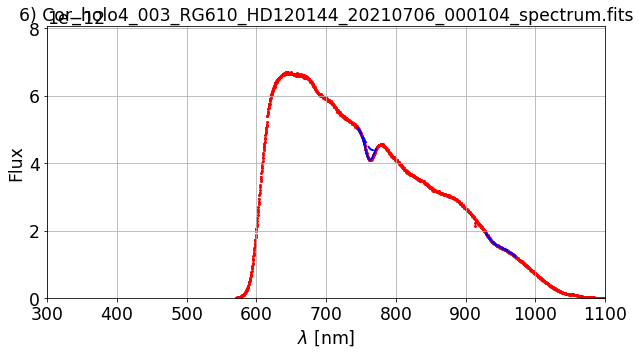

Line Tabulated  Detected   Shift   ...   Chisq    Eqwidth_mod Eqwidth_data
         nm        nm        nm    ...  reduced        nm          nm     
---- --------- --------- --------- ... ---------- ----------- ------------
         760.3 761.30066 1.0006498 ... 0.91600496   0.9810396     2.547203
2.547203


In [59]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,7):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    #wlidx=np.where(np.logical_and( s.lambdas>=WLMIN, s.lambdas<=WLMAX))[0]
    #print(wlidx)
    #wl=s.lambdas[wlidx]
    
    #specify the lines  
    lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)
    s.lines = lines
    
    global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)
    
    print(IDXSEL,") ",filename_SEL)
    thetitle=str(IDXSEL)+") "+filename_SEL
    
    fig = plt.figure(figsize=(10,5))
    plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
    lines.plot_detected_lines(plt.gca())
    plt.title(thetitle)
    plt.show()
    
    print(lines.print_detected_lines())
    print(lines.print_detected_lines()[0]["Eqwidth_data"])
    df_infos.at[IDXSEL,"eqw_o2_spec"] = lines.print_detected_lines()[0]["Eqwidth_data"]*10.
    
    

In [60]:
print(lines.print_detected_lines())

Line Tabulated  Detected   Shift   ...   Chisq    Eqwidth_mod Eqwidth_data
         nm        nm        nm    ...  reduced        nm          nm     
---- --------- --------- --------- ... ---------- ----------- ------------
         760.3 761.30066 1.0006498 ... 0.91600496   0.9810396     2.547203


In [61]:
type(lines.print_detected_lines())

astropy.table.table.Table

In [62]:
print(lines.print_detected_lines()[0]["Eqwidth_data"])

2.547203


In [63]:
df_infos

,date_obs,airmass,temperature,pressure,humidity,reftime,eqw_h2o,eqw_o2,eqw_o2_spec
idx,,,,,,,,,
0,2021-07-07T01:16:18.894,1.113036,7.0,742.35,16.0,0.000000,NaN,NaN,16.524806
1,2021-07-07T01:16:46.919,1.113668,7.0,742.35,16.0,0.007785,NaN,NaN,12.212942
2,2021-07-07T01:17:11.390,1.114239,7.0,742.35,16.0,0.014582,NaN,NaN,32.985058
3,2021-07-07T01:17:35.866,1.114817,7.0,742.25,15.0,0.021381,NaN,NaN,24.538293
4,2021-07-07T01:18:00.451,1.115396,7.0,742.25,15.0,0.028210,NaN,NaN,24.642198
5,2021-07-07T01:18:24.863,1.115972,7.1,742.35,15.0,0.034991,NaN,NaN,28.974421
6,2021-07-07T01:18:49.445,1.116559,7.1,742.35,15.0,0.041820,NaN,NaN,25.472031
7,2021-07-07T01:19:13.841,1.117143,7.1,742.35,15.0,0.048596,NaN,NaN,NaN


# Loop on spectrum, compute O2 line equivalent width with specutils 

0 )  Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits


2021-07-07 21:36:44  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:36:44  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


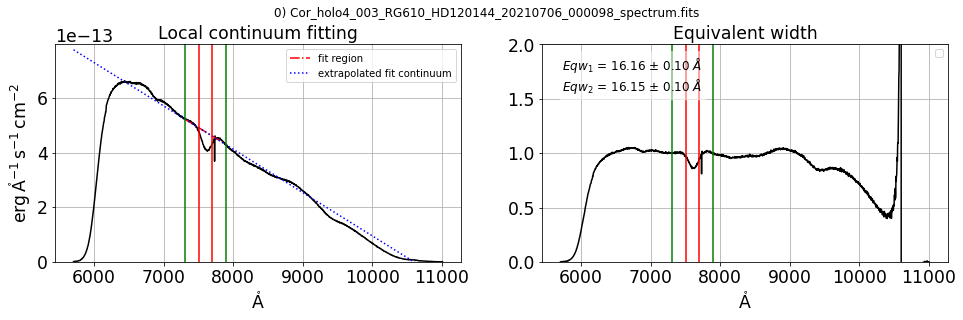

0 ) eqw_O2= 16.16175369457099
1 )  Cor_holo4_003_RG610_HD120144_20210706_000099_spectrum.fits


2021-07-07 21:37:14  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:37:14  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


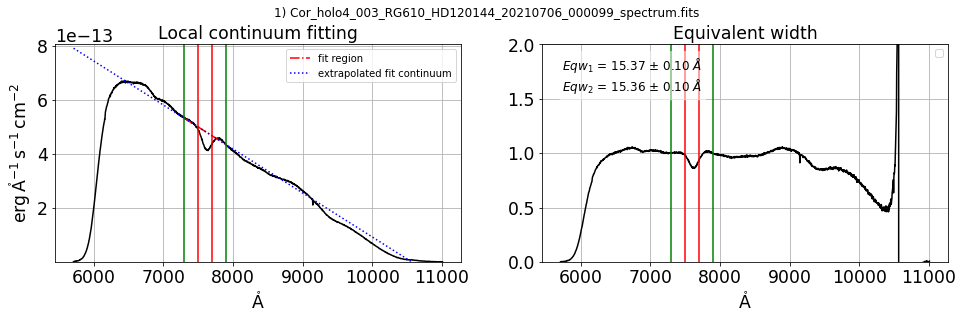

1 ) eqw_O2= 15.368620324953412
2 )  Cor_holo4_003_RG610_HD120144_20210706_000100_spectrum.fits


2021-07-07 21:37:45  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:37:45  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


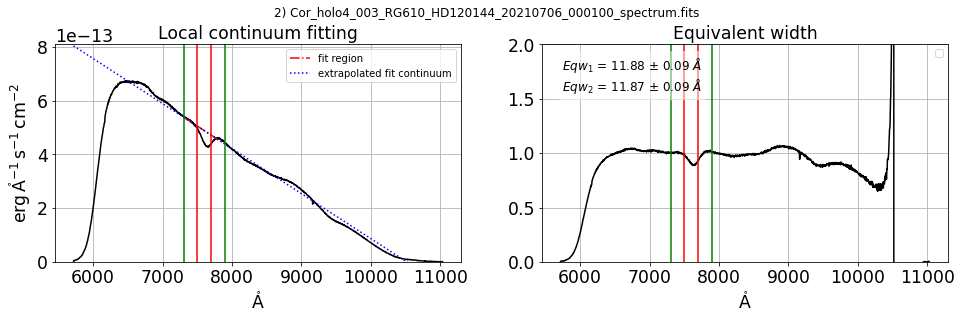

2 ) eqw_O2= 11.884211061433206
3 )  Cor_holo4_003_RG610_HD120144_20210706_000101_spectrum.fits


2021-07-07 21:38:16  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:38:16  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


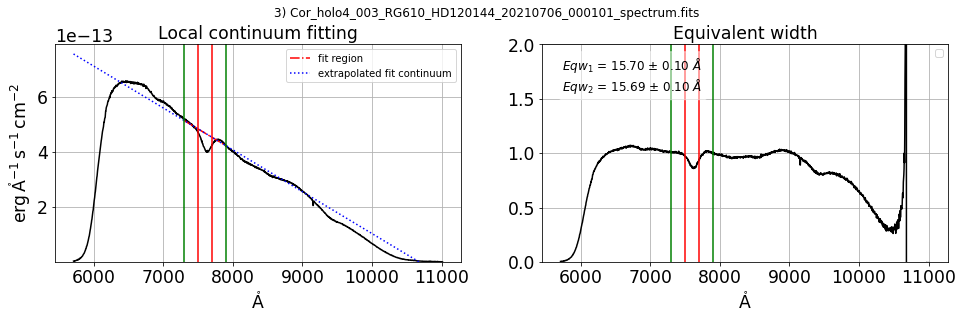

3 ) eqw_O2= 15.700062127737482
4 )  Cor_holo4_003_RG610_HD120144_20210706_000102_spectrum.fits


2021-07-07 21:38:46  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:38:46  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


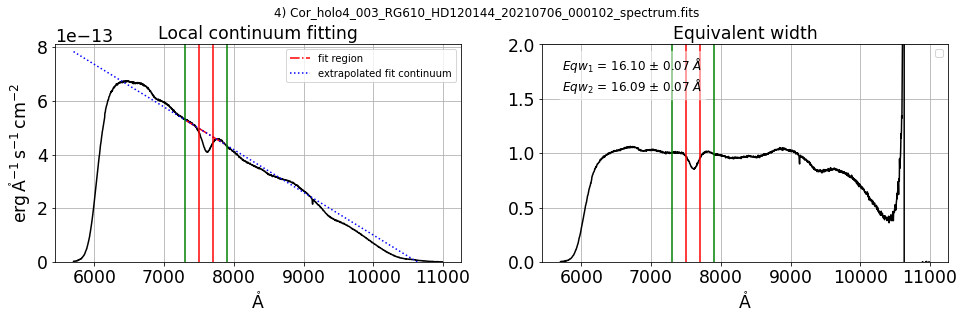

4 ) eqw_O2= 16.09827319913336
5 )  Cor_holo4_003_RG610_HD120144_20210706_000103_spectrum.fits


2021-07-07 21:39:16  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:39:16  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


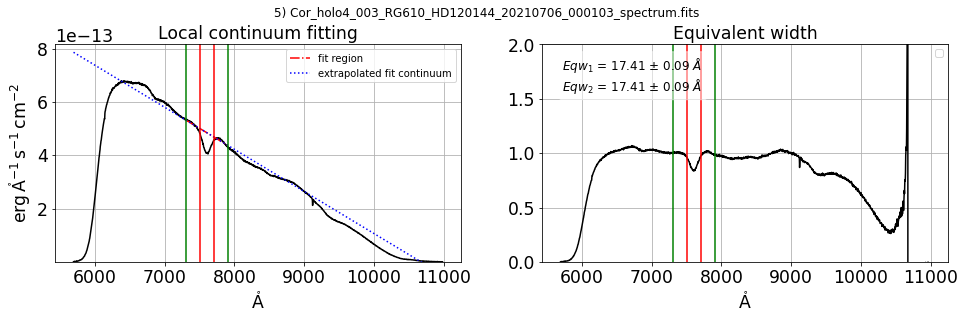

5 ) eqw_O2= 17.414697869326318
6 )  Cor_holo4_003_RG610_HD120144_20210706_000104_spectrum.fits


2021-07-07 21:39:46  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:39:46  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


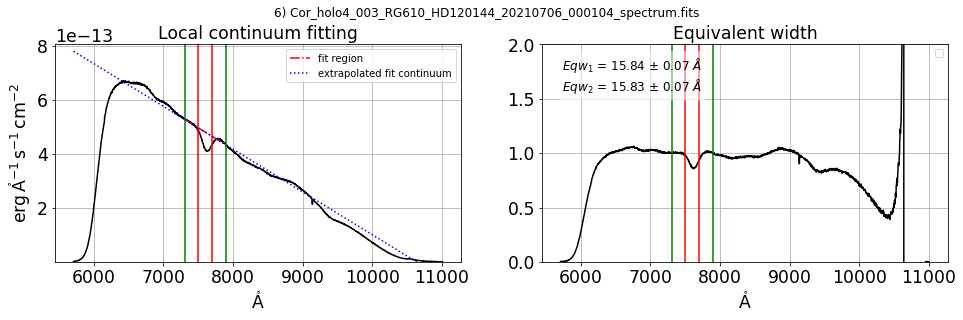

6 ) eqw_O2= 15.83930959466693
7 )  Cor_holo4_003_RG610_HD120144_20210706_000105_spectrum.fits


2021-07-07 21:40:15  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:40:15  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


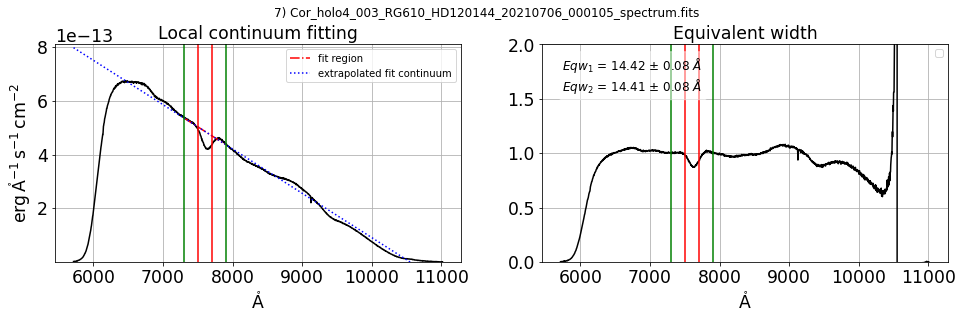

7 ) eqw_O2= 14.416905172366398


In [64]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,8):

    
    
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    
    print(IDXSEL,") ",filename_SEL)
    
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # O2 line
    wlmin=10*(O2_1.wavelength-30)*u.AA
    wlmax=10*(O2_1.wavelength+30)*u.AA
    wlminline=10*(O2_1.wavelength-10)*u.AA
    wlmaxline=10*(O2_1.wavelength+10)*u.AA
    
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    #eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw10)
    
    df_infos.at[IDXSEL,"eqw_o2"] =  eqw10

# Loop on spectrum, compute H2O line equivalent width with specutils 

2021-07-07 21:40:45  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:40:45  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


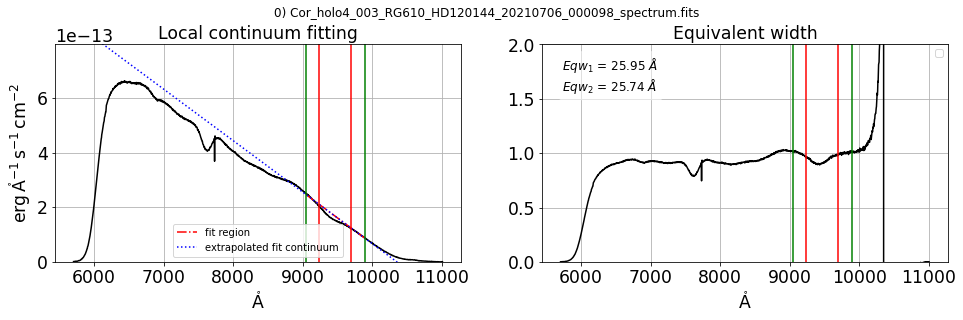

0 ) eqw_O2= 25.94972336635908


2021-07-07 21:40:47  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:40:47  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


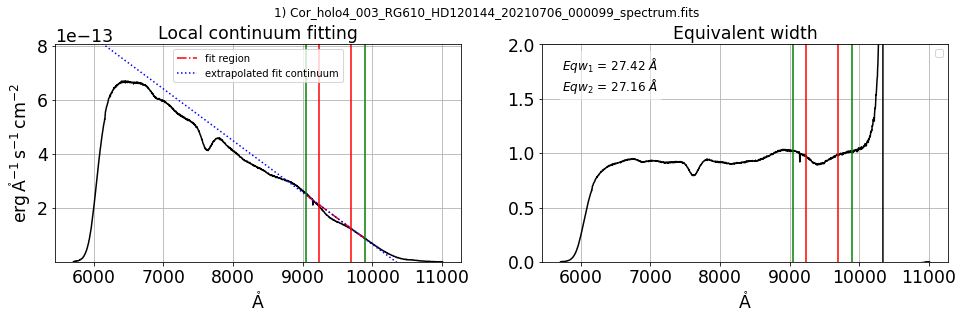

1 ) eqw_O2= 27.418084078383856


2021-07-07 21:40:50  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:40:50  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


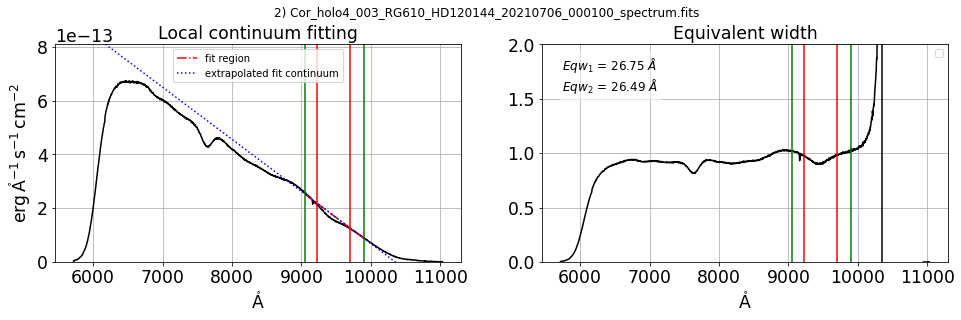

2 ) eqw_O2= 26.74707516832399


2021-07-07 21:40:52  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:40:52  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


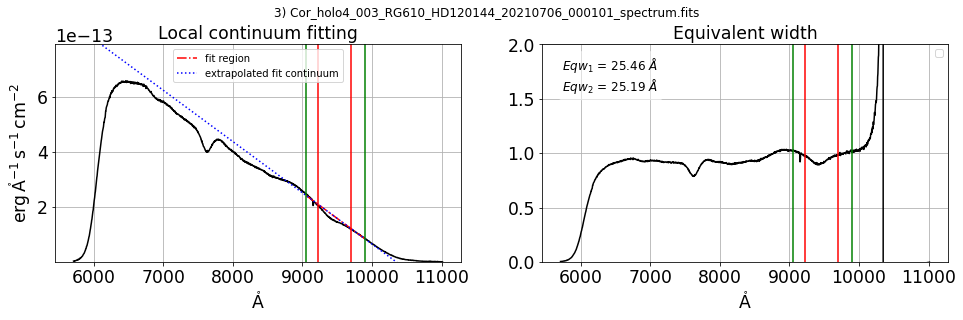

3 ) eqw_O2= 25.458869550575514


2021-07-07 21:40:54  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:40:54  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


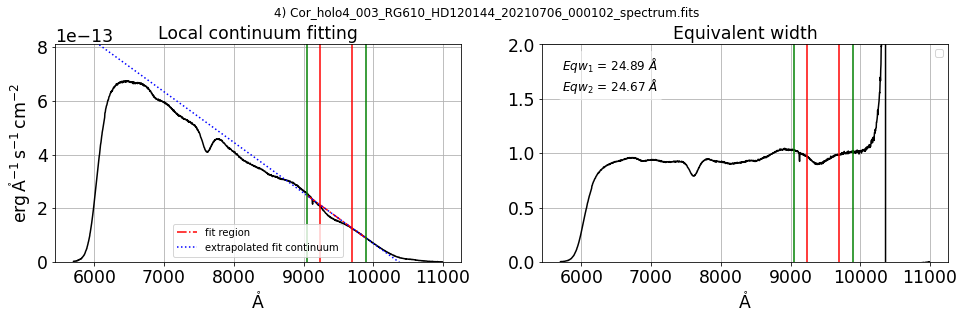

4 ) eqw_O2= 24.887811554967755


2021-07-07 21:40:56  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:40:56  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


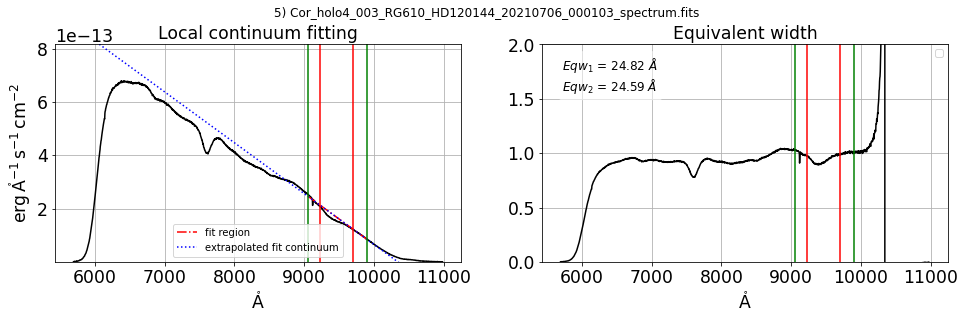

5 ) eqw_O2= 24.818414496659898


2021-07-07 21:40:58  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:40:58  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


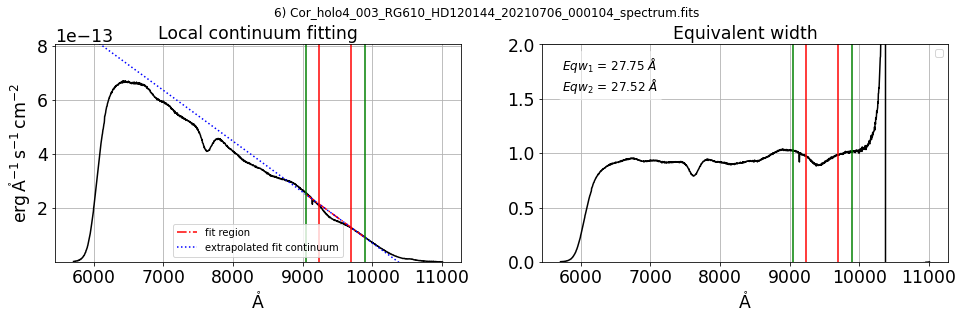

6 ) eqw_O2= 27.75113611443328


2021-07-07 21:41:01  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.
2021-07-07 21:41:01  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


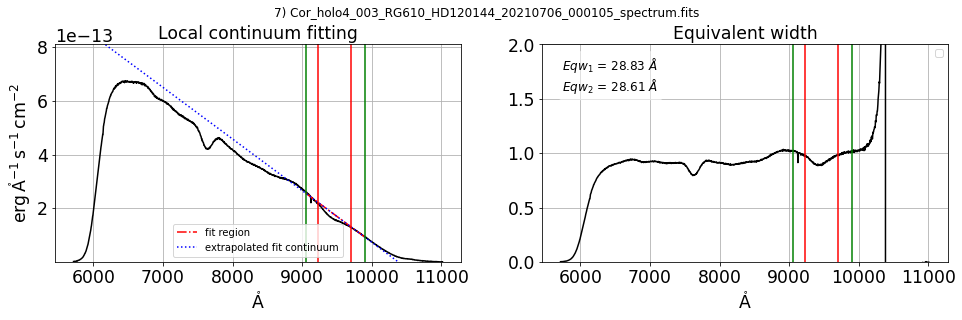

7 ) eqw_O2= 28.827901146055865


In [65]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,8):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # H2O line
    
    wlmin=10*(H2O_1.wavelength-30)*u.AA
    wlmax=10*(H2O_2.wavelength+30)*u.AA
    wlminline=10*(H2O_1.wavelength-12)*u.AA
    wlmaxline=10*(H2O_2.wavelength+10)*u.AA
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    eqw1,eqw2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    #eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw1)
    
    df_infos.at[IDXSEL,"eqw_h2o"] =  eqw1

In [66]:
df_infos

,date_obs,airmass,temperature,pressure,humidity,reftime,eqw_h2o,eqw_o2,eqw_o2_spec
idx,,,,,,,,,
0,2021-07-07T01:16:18.894,1.113036,7.0,742.35,16.0,0.000000,25.949723,16.161754,16.524806
1,2021-07-07T01:16:46.919,1.113668,7.0,742.35,16.0,0.007785,27.418084,15.368620,12.212942
2,2021-07-07T01:17:11.390,1.114239,7.0,742.35,16.0,0.014582,26.747075,11.884211,32.985058
3,2021-07-07T01:17:35.866,1.114817,7.0,742.25,15.0,0.021381,25.458870,15.700062,24.538293
4,2021-07-07T01:18:00.451,1.115396,7.0,742.25,15.0,0.028210,24.887812,16.098273,24.642198
5,2021-07-07T01:18:24.863,1.115972,7.1,742.35,15.0,0.034991,24.818414,17.414698,28.974421
6,2021-07-07T01:18:49.445,1.116559,7.1,742.35,15.0,0.041820,27.751136,15.839310,25.472031
7,2021-07-07T01:19:13.841,1.117143,7.1,742.35,15.0,0.048596,28.827901,14.416905,NaN


In [67]:
df_infos.to_csv("eqw.csv")

Text(0.5, 1.0, 'Equivalent Widths vs date')

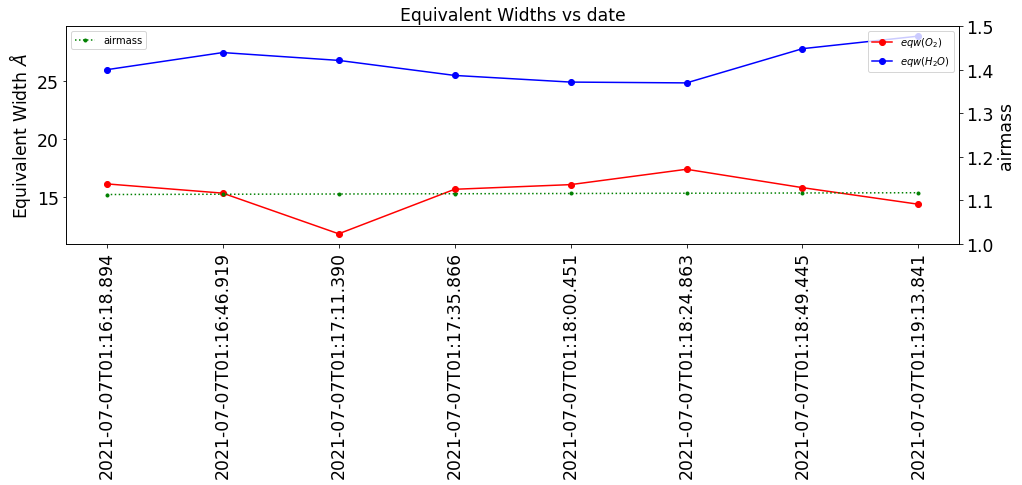

In [68]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['date_obs'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass")
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")

Text(0.5, 1.0, 'Equivalent Widths vs date')

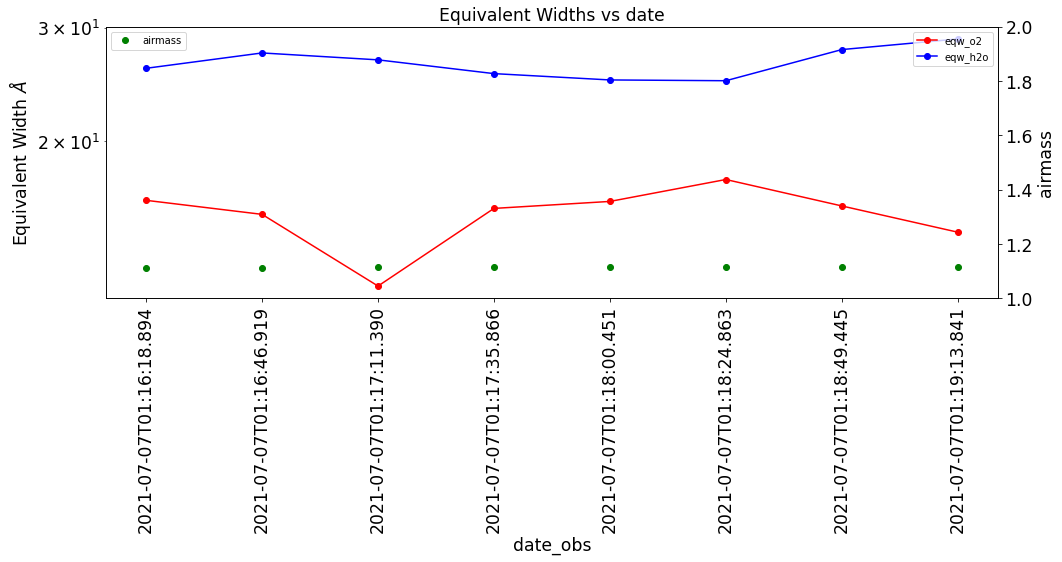

In [69]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
df_infos.plot(ax=ax,x="date_obs", y=["eqw_o2","eqw_h2o"],color=["r","b"],marker="o");
#plt.gcf().autofmt_xdate(rotation=90) 
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax.set_yscale("log")

ax2 = ax.twinx()
df_infos.plot(ax=ax2,x="date_obs", y="airmass",color=["g"],marker="o",lw=0);
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax2.set_ylim(1,2)
ax2.xaxis.set_tick_params(rotation=90)
ax.set_title("Equivalent Widths vs date")


Text(0.5, 1.0, 'Equivalent Widths vs date')

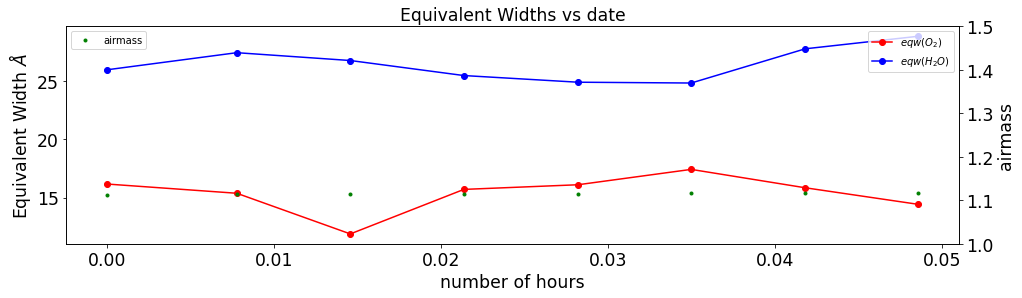

In [70]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['reftime'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['reftime'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['reftime'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass",lw=0)
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")